<a href="https://colab.research.google.com/github/juhang-lee/AI_VISION/blob/juhang-lee-patch-1/5_day/2.mediapipe/3.image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 분할기

## 가져오기 및 설정
이 MediaPipe 샘플을 실행하기 위한 기본 가져오기부터 시작해 보겠습니다.

In [1]:
!pip install -q mediapipe==0.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 36.6 MB/s eta 0:00:00


## 이미지 분할기 모델 다운로드

다음으로 해야 할 일은 이 데모에 사용될 이미지 분할 모델을 다운로드하는 것입니다. 이 경우 DeepLab v3 모델을 사용합니다.

In [2]:
#@title 여기에서 다운로드를 시작하세요.
!wget -O deeplabv3.tflite -q https://storage.googleapis.com/mediapipe-models/image_segmenter/deeplab_v3/float32/1/deeplab_v3.tflite

## 테스트 이미지 다운로드

모델을 다운로드한 후에는 테스트에 사용할 수 있는 이미지를 가져와야 합니다! 단일 이미지로 작업하는 동안 `IMAGE_FILENAMES` 배열에 저장할 이미지 모음을 다운로드할 수 있다는 점은 주목할 가치가 있습니다.

In [3]:
import urllib

IMAGE_FILENAMES = ['segmentation_input_rotation0.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
  urllib.request.urlretrieve(url, name)

## 다운로드한 이미지 미리보기

테스트 이미지를 다운로드한 후 표시해 보세요.

segmentation_input_rotation0.jpg


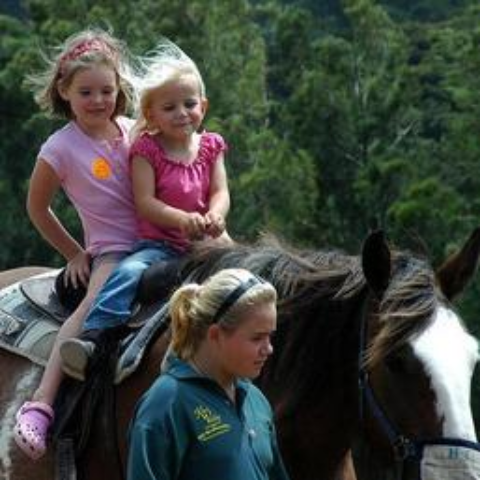

In [4]:
import cv2
from google.colab.patches import cv2_imshow
import math

# Height and width that will be used by the model
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


# Preview the image(s)
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)

## 추론 실행 및 결과 시각화
이미지 분할 MediaPipe 작업을 사용하여 추론을 실행하려면 모델을 사용하여 'ImageSegmenter'를 초기화해야 합니다. 이 예에서는 이미지의 배경과 전경을 분리하고 별도의 색상을 적용하여 각각의 독특한 영역이 존재하는 부분을 강조합니다. 여기서 이미지 분할은 신뢰도에 따라 발견된 각 항목에 카테고리를 적용하는 카테고리 마스크를 사용합니다.

Segmentation mask of segmentation_input_rotation0.jpg:


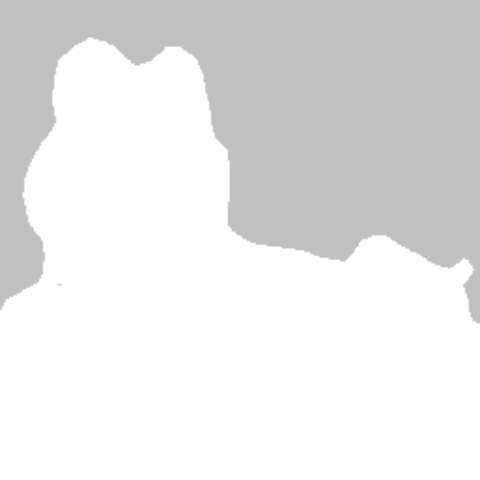

In [5]:
import numpy as np
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision


BG_COLOR = (192, 192, 192) # gray
MASK_COLOR = (255, 255, 255) # white


# Create the options that will be used for ImageSegmenter
base_options = python.BaseOptions(model_asset_path='deeplabv3.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:

  # Loop through demo image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe image file that will be segmented
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the masks for the segmented image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    # Generate solid color images for showing the output segmentation mask.
    image_data = image.numpy_view()
    fg_image = np.zeros(image_data.shape, dtype=np.uint8)
    fg_image[:] = MASK_COLOR
    bg_image = np.zeros(image_data.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR

    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.2
    output_image = np.where(condition, fg_image, bg_image)

    print(f'Segmentation mask of {name}:')
    resize_and_show(output_image)

이제 이미지의 전경과 배경을 분리하는 방법을 알았으니 한 단계 더 나아가 Google 행아웃에서 제공하는 것과 유사한 효과를 위해 배경을 흐리게 해 보겠습니다.

Blurred background of segmentation_input_rotation0.jpg:


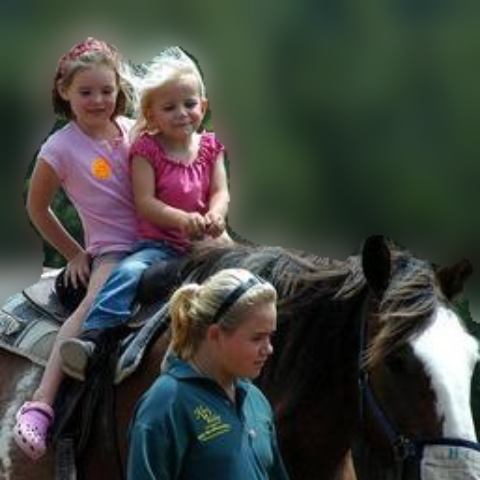

In [6]:
# Blur the image background based on the segmentation mask.

# Create the segmenter
with python.vision.ImageSegmenter.create_from_options(options) as segmenter:

  # Loop through available image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe Image
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the category masks for the image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    # Convert the BGR image to RGB
    image_data = cv2.cvtColor(image.numpy_view(), cv2.COLOR_BGR2RGB)

    # Apply effects
    blurred_image = cv2.GaussianBlur(image_data, (55,55), 0)
    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1
    output_image = np.where(condition, image_data, blurred_image)

    print(f'Blurred background of {image_file_name}:')
    resize_and_show(output_image)